In [1]:
import gym
from collections import namedtuple
import itertools
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
import collections
import random
import matplotlib.pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")


c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-ram-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Adventure-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding environment ALE/Adventure-ram-v5
  logger.warn("Overriding environment {}".format(id))
c:\Users\37103\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\envs\registration.py:216: UserWarning: WARN: Overriding enviro

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample()是重参数化采样函数
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)  # 计算tanh_normal分布的对数概率密度
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)  # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        return self.fc2(x)


class SAC:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim,
                               action_bound).to(device)  # 策略网络
        # 第一个Q网络
        self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 第二个Q网络
        self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNet(state_dim, hidden_dim,
                                         action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNet(state_dim, hidden_dim,
                                         action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(device)
        action = self.actor(state)[0]
        return [action.item()]

    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(device)
        rewards = (rewards + 8.0) / 8.0  # 对倒立摆环境的奖励进行重塑

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [3]:
class Swish(nn.Module):
    ''' Swish激活函数 '''
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)


def init_weights(m):
    ''' 初始化模型权重 '''
    def truncated_normal_init(t, mean=0.0, std=0.01):
        torch.nn.init.normal_(t, mean=mean, std=std)
        while True:
            cond = (t < mean - 2 * std) | (t > mean + 2 * std)
            if not torch.sum(cond):
                break
            t = torch.where(
                cond,
                torch.nn.init.normal_(torch.ones(t.shape, device=device),
                                      mean=mean,
                                      std=std), t)
        return t

    if type(m) == nn.Linear or isinstance(m, FCLayer):
        truncated_normal_init(m.weight, std=1 / (2 * np.sqrt(m._input_dim)))
        m.bias.data.fill_(0.0)


class FCLayer(nn.Module):
    ''' 集成之后的全连接层 '''
    def __init__(self, input_dim, output_dim, ensemble_size, activation):
        super(FCLayer, self).__init__()
        self._input_dim, self._output_dim = input_dim, output_dim
        self.weight = nn.Parameter(
            torch.Tensor(ensemble_size, input_dim, output_dim).to(device))
        self._activation = activation
        self.bias = nn.Parameter(
            torch.Tensor(ensemble_size, output_dim).to(device))

    def forward(self, x):
        return self._activation(
            torch.add(torch.bmm(x, self.weight), self.bias[:, None, :]))

In [4]:
class EnsembleModel(nn.Module):
    ''' 环境模型集成 '''
    def __init__(self,
                 state_dim,
                 action_dim,
                 model_alpha,
                 ensemble_size=5,
                 learning_rate=1e-3):
        super(EnsembleModel, self).__init__()
        # 输出包括均值和方差,因此是状态与奖励维度之和的两倍
        self._output_dim = (state_dim + 1) * 2
        self._model_alpha = model_alpha  # 模型损失函数中加权时的权重
        self._max_logvar = nn.Parameter((torch.ones(
            (1, self._output_dim // 2)).float() / 2).to(device),
                                        requires_grad=False)
        self._min_logvar = nn.Parameter((-torch.ones(
            (1, self._output_dim // 2)).float() * 10).to(device),
                                        requires_grad=False)

        self.layer1 = FCLayer(state_dim + action_dim, 200, ensemble_size,
                              Swish())
        self.layer2 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer3 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer4 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer5 = FCLayer(200, self._output_dim, ensemble_size,
                              nn.Identity())
        self.apply(init_weights)  # 初始化环境模型中的参数
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, return_log_var=False):
        ret = self.layer5(self.layer4(self.layer3(self.layer2(
            self.layer1(x)))))
        mean = ret[:, :, :self._output_dim // 2]
        # 在PETS算法中,将方差控制在最小值和最大值之间
        logvar = self._max_logvar - F.softplus(
            self._max_logvar - ret[:, :, self._output_dim // 2:])
        logvar = self._min_logvar + F.softplus(logvar - self._min_logvar)
        return mean, logvar if return_log_var else torch.exp(logvar)

    def loss(self, mean, logvar, labels, use_var_loss=True):
        inverse_var = torch.exp(-logvar)
        if use_var_loss:
            mse_loss = torch.mean(torch.mean(torch.pow(mean - labels, 2) *
                                             inverse_var,
                                             dim=-1),
                                  dim=-1)
            var_loss = torch.mean(torch.mean(logvar, dim=-1), dim=-1)
            total_loss = torch.sum(mse_loss) + torch.sum(var_loss)
        else:
            mse_loss = torch.mean(torch.pow(mean - labels, 2), dim=(1, 2))
            total_loss = torch.sum(mse_loss)
        return total_loss, mse_loss

    def train(self, loss):
        self.optimizer.zero_grad()
        loss += self._model_alpha * torch.sum(
            self._max_logvar) - self._model_alpha * torch.sum(self._min_logvar)
        loss.backward()
        self.optimizer.step()


class EnsembleDynamicsModel:
    ''' 环境模型集成,加入精细化的训练 '''
    def __init__(self, state_dim, action_dim, model_alpha=0.01, num_network=5):
        self._num_network = num_network
        self._state_dim, self._action_dim = state_dim, action_dim
        self.model = EnsembleModel(state_dim,
                                   action_dim,
                                   model_alpha,
                                   ensemble_size=num_network)
        self._epoch_since_last_update = 0

    def train(self,
              inputs,
              labels,
              batch_size=64,
              holdout_ratio=0.1,
              max_iter=20):
        # 设置训练集与验证集
        permutation = np.random.permutation(inputs.shape[0])
        inputs, labels = inputs[permutation], labels[permutation]
        num_holdout = int(inputs.shape[0] * holdout_ratio)
        train_inputs, train_labels = inputs[num_holdout:], labels[num_holdout:]
        holdout_inputs, holdout_labels = inputs[:
                                                num_holdout], labels[:
                                                                     num_holdout]
        holdout_inputs = torch.from_numpy(holdout_inputs).float().to(device)
        holdout_labels = torch.from_numpy(holdout_labels).float().to(device)
        holdout_inputs = holdout_inputs[None, :, :].repeat(
            [self._num_network, 1, 1])
        holdout_labels = holdout_labels[None, :, :].repeat(
            [self._num_network, 1, 1])

        # 保留最好的结果
        self._snapshots = {i: (None, 1e10) for i in range(self._num_network)}

        for epoch in itertools.count():
            # 定义每一个网络的训练数据
            train_index = np.vstack([
                np.random.permutation(train_inputs.shape[0])
                for _ in range(self._num_network)
            ])
            # 所有真实数据都用来训练
            for batch_start_pos in range(0, train_inputs.shape[0], batch_size):
                batch_index = train_index[:, batch_start_pos:batch_start_pos +
                                          batch_size]
                train_input = torch.from_numpy(
                    train_inputs[batch_index]).float().to(device)
                train_label = torch.from_numpy(
                    train_labels[batch_index]).float().to(device)

                mean, logvar = self.model(train_input, return_log_var=True)
                loss, _ = self.model.loss(mean, logvar, train_label)
                self.model.train(loss)

            with torch.no_grad():
                mean, logvar = self.model(holdout_inputs, return_log_var=True)
                _, holdout_losses = self.model.loss(mean,
                                                    logvar,
                                                    holdout_labels,
                                                    use_var_loss=False)
                holdout_losses = holdout_losses.cpu()
                break_condition = self._save_best(epoch, holdout_losses)
                if break_condition or epoch > max_iter:  # 结束训练
                    break

    def _save_best(self, epoch, losses, threshold=0.1):
        updated = False
        for i in range(len(losses)):
            current = losses[i]
            _, best = self._snapshots[i]
            improvement = (best - current) / best
            if improvement > threshold:
                self._snapshots[i] = (epoch, current)
                updated = True
        self._epoch_since_last_update = 0 if updated else self._epoch_since_last_update + 1
        return self._epoch_since_last_update > 5

    def predict(self, inputs, batch_size=64):
        inputs = np.tile(inputs, (self._num_network, 1, 1))
        inputs = torch.tensor(inputs, dtype=torch.float).to(device)
        mean, var = self.model(inputs, return_log_var=False)
        return mean.detach().cpu().numpy(), var.detach().cpu().numpy()


class FakeEnv:
    def __init__(self, model):
        self.model = model

    def step(self, obs, act):
        inputs = np.concatenate((obs, act), axis=-1)
        ensemble_model_means, ensemble_model_vars = self.model.predict(inputs)
        ensemble_model_means[:, :, 1:] += obs
        ensemble_model_stds = np.sqrt(ensemble_model_vars)
        ensemble_samples = ensemble_model_means + np.random.normal(
            size=ensemble_model_means.shape) * ensemble_model_stds

        num_models, batch_size, _ = ensemble_model_means.shape
        models_to_use = np.random.choice(
            [i for i in range(self.model._num_network)], size=batch_size)
        batch_inds = np.arange(0, batch_size)
        samples = ensemble_samples[models_to_use, batch_inds]
        rewards, next_obs = samples[:, :1][0][0], samples[:, 1:][0]
        return rewards, next_obs

In [5]:
class MBPO:
    def __init__(self, env, agent, fake_env, env_pool, model_pool,
                 rollout_length, rollout_batch_size, real_ratio, num_episode):

        self.env = env
        self.agent = agent
        self.fake_env = fake_env
        self.env_pool = env_pool
        self.model_pool = model_pool
        self.rollout_length = rollout_length
        self.rollout_batch_size = rollout_batch_size
        self.real_ratio = real_ratio
        self.num_episode = num_episode

    def rollout_model(self):
        observations, _, _, _, _ = self.env_pool.sample(
            self.rollout_batch_size)
        for obs in observations:
            for i in range(self.rollout_length):
                action = self.agent.take_action(obs)
                reward, next_obs = self.fake_env.step(obs, action)
                self.model_pool.add(obs, action, reward, next_obs, False)
                obs = next_obs

    def update_agent(self, policy_train_batch_size=64):
        env_batch_size = int(policy_train_batch_size * self.real_ratio)
        model_batch_size = policy_train_batch_size - env_batch_size
        for epoch in range(10):
            env_obs, env_action, env_reward, env_next_obs, env_done = self.env_pool.sample(
                env_batch_size)
            if self.model_pool.size() > 0:
                model_obs, model_action, model_reward, model_next_obs, model_done = self.model_pool.sample(
                    model_batch_size)
                obs = np.concatenate((env_obs, model_obs), axis=0)
                action = np.concatenate((env_action, model_action), axis=0)
                next_obs = np.concatenate((env_next_obs, model_next_obs),
                                          axis=0)
                reward = np.concatenate((env_reward, model_reward), axis=0)
                done = np.concatenate((env_done, model_done), axis=0)
            else:
                obs, action, next_obs, reward, done = env_obs, env_action, env_next_obs, env_reward, env_done
            transition_dict = {
                'states': obs,
                'actions': action,
                'next_states': next_obs,
                'rewards': reward,
                'dones': done
            }
            self.agent.update(transition_dict)

    def train_model(self):
        obs, action, reward, next_obs, done = self.env_pool.return_all_samples(
        )
        inputs = np.concatenate((obs, action), axis=-1)
        reward = np.array(reward)
        labels = np.concatenate(
            (np.reshape(reward, (reward.shape[0], -1)), next_obs - obs),
            axis=-1)
        self.fake_env.model.train(inputs, labels)

    def explore(self):
        obs, done, episode_return = self.env.reset(), False, 0
        while not done:
            action = self.agent.take_action(obs)
            next_obs, reward, done, _ = self.env.step(action)
            self.env_pool.add(obs, action, reward, next_obs, done)
            obs = next_obs
            episode_return += reward
        return episode_return

    def train(self):
        return_list = []
        explore_return = self.explore()  # 随机探索采取数据
        print('episode: 1, return: %d' % explore_return)
        return_list.append(explore_return)

        for i_episode in range(self.num_episode - 1):
            obs, done, episode_return = self.env.reset(), False, 0
            step = 0
            while not done:
                if step % 50 == 0:
                    self.train_model()
                    self.rollout_model()
                action = self.agent.take_action(obs)
                next_obs, reward, done, _ = self.env.step(action)
                self.env_pool.add(obs, action, reward, next_obs, done)
                obs = next_obs
                episode_return += reward

                self.update_agent()
                step += 1
            return_list.append(episode_return)
            print('episode: %d, return: %d' % (i_episode + 2, episode_return))
        return return_list


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size):
        if batch_size > len(self.buffer):
            return self.return_all_samples()
        else:
            transitions = random.sample(self.buffer, batch_size)
            state, action, reward, next_state, done = zip(*transitions)
            return np.array(state), action, reward, np.array(next_state), done

    def return_all_samples(self):
        all_transitions = list(self.buffer)
        state, action, reward, next_state, done = zip(*all_transitions)
        return np.array(state), action, reward, np.array(next_state), done

C:\Users\37103\AppData\Local\Temp\ipykernel_22832\342446539.py:67: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  state = torch.tensor([state], dtype=torch.float).to(device)


episode: 1, return: -1504
episode: 2, return: -1602
episode: 3, return: -1343
episode: 4, return: -971
episode: 5, return: -1507
episode: 6, return: -1525
episode: 7, return: -1450
episode: 8, return: -1648
episode: 9, return: -1619
episode: 10, return: -1619
episode: 11, return: -1636
episode: 12, return: -1657
episode: 13, return: -1681
episode: 14, return: -1148
episode: 15, return: -1167
episode: 16, return: -1671
episode: 17, return: -1063
episode: 18, return: -1630
episode: 19, return: -1174
episode: 20, return: -1068


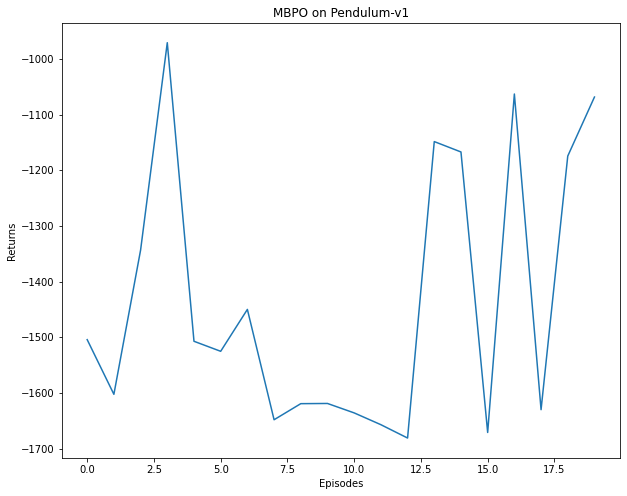

In [6]:
real_ratio = 0.5
env_name = 'Pendulum-v1'
env = gym.make(env_name)
num_episodes = 20
actor_lr = 5e-4
critic_lr = 5e-3
alpha_lr = 1e-3
hidden_dim = 128
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
target_entropy = -1
model_alpha = 0.01  # 模型损失函数中的加权权重
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值

rollout_batch_size = 1000
rollout_length = 1  # 推演长度k,推荐更多尝试
model_pool_size = rollout_batch_size * rollout_length

agent = SAC(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
            critic_lr, alpha_lr, target_entropy, tau, gamma)
model = EnsembleDynamicsModel(state_dim, action_dim, model_alpha)
fake_env = FakeEnv(model)
env_pool = ReplayBuffer(buffer_size)
model_pool = ReplayBuffer(model_pool_size)
mbpo = MBPO(env, agent, fake_env, env_pool, model_pool, rollout_length,
            rollout_batch_size, real_ratio, num_episodes)

return_list = mbpo.train()

episodes_list = list(range(len(return_list)))
plt.figure(figsize=(10, 8))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('MBPO on {}'.format(env_name))
plt.show()

# episode: 1, return: -1083
# episode: 2, return: -1324
# episode: 3, return: -979
# episode: 4, return: -130
# episode: 5, return: -246
# episode: 6, return: -2
# episode: 7, return: -239
# episode: 8, return: -2
# episode: 9, return: -122
# episode: 10, return: -236
# episode: 11, return: -238
# episode: 12, return: -2
# episode: 13, return: -127
# episode: 14, return: -128
# episode: 15, return: -125
# episode: 16, return: -124
# episode: 17, return: -125
# episode: 18, return: -247
# episode: 19, return: -127
# episode: 20, return: -129